## Code to compute properties of MHWs

#### Created by: Ligin Joseph


In [40]:
import xarray as xr
import matplotlib
import numpy as np
from scipy.ndimage import label
from tqdm import tqdm
import pandas as pd
import cmocean

In [2]:
def compute_daily_anomaly(climatology, sst_data):
    # Convert the 'time' dimension to 'dayofyear'
    sst_data['dayofyear'] = sst_data['time'].dt.dayofyear
    
    # Align the 'dayofyear' dimension of sst_data with the climatology
    sst_data = sst_data.assign_coords(dayofyear=sst_data.dayofyear)
    
    # Compute the daily anomaly
    daily_anomaly = sst_data.groupby('dayofyear') - climatology
    
    return daily_anomaly

In [3]:
## load data
mhw = xr.open_dataset('mhw_1982_2023.nc').__xarray_dataarray_variable__
sst = xr.open_dataset('../Data/Observations/OISST/OISST_1d_SST_AS_1982_2023.nc').sst
mhw_clim = xr.open_dataset('climatology_90th_percentile_smoothed.nc').sst

In [4]:
## compute anomales based on 90th percentile
sst_anom = compute_daily_anomaly(mhw_clim, sst)

In [61]:
def find_events(mhw_array):
    """ 
    Function to isolate the MHWs. This function will detect
    the starting and ending index of 1s in mhw data and store
    it as (start_index,end_index).
    """
    events = []
    start = None
    for i, value in enumerate(mhw_array):
        if value == 1 and start is None:
            start = i
        elif value == 0 and start is not None:
            events.append((start, i - 1))
            start = None
    if start is not None:
        events.append((start, len(mhw_array) - 1))
    return events

def calculate_event_properties(sst_array, mhw_array, dates):
    """
    Function to compute the properties of MHWs
    like intensity, duration, start date and end date etc
    
    """
    events = find_events(mhw_array)
    event_properties = {
        'start_date': [],
        'end_date': [],
        'duration': [],
        'cumulative_intensity': [],
        'mean_intensity': []
    }
    
    for start, end in events:
        sst_event = sst_array[start:end + 1]      ## Slice through MHW event
        cumulative_intensity = np.sum(sst_event)  ## Compute cumulative intensity
        mean_intensity = np.mean(sst_event)       ## Compute mean intensity
        duration = end - start + 1                ## Duration
        start_date = dates[start]                 ## Start date
        end_date = dates[end]                     ## End date

        ##Append for all events
        
        event_properties['start_date'].append(start_date)
        event_properties['end_date'].append(end_date)
        event_properties['duration'].append(duration)
        event_properties['cumulative_intensity'].append(cumulative_intensity)
        event_properties['mean_intensity'].append(mean_intensity)
    
    max_events = max(len(prop) for prop in event_properties.values())
    for key in event_properties:
        while len(event_properties[key]) < max_events:
            event_properties[key].append(np.nan)
    
    return event_properties

def process_all_points(sst, mhw,var):
    """
    Previous function is for dealing with only 1 point at a time.
    This function will run the previous functions for all lat lon combinations
    and will return the mean of the property along all events.
    
    """
    latitudes = sst.lat.values
    longitudes = sst.lon.values
    n_lats = len(latitudes)
    n_lons = len(longitudes)
    
    mean_intensities = np.full((n_lats, n_lons), np.nan)
    
    total_points = n_lats * n_lons
    with tqdm(total=total_points, desc="Processing Grid Points") as pbar:   ##For progress bar
        for lat_idx in range(n_lats):                                       ## Looping through all lats
            for lon_idx in range(n_lons):                                   ## Looping through all lons
                sst_single = sst[:, lat_idx, lon_idx].values
                mhw_single = mhw[:, lat_idx, lon_idx].values
                dates = sst.time.values
                props = calculate_event_properties(sst_single, mhw_single, dates)
                
                mean_intensities[lat_idx, lon_idx] = np.nanmean(props[var])
                pbar.update(1)
    
    return mean_intensities       ## will return a dict

def create_spatial_dataarray(mean_intensities, sst,var):
    """
    Convert dict to xarray dataset 
    
    """
    latitudes = sst.lat.values
    longitudes = sst.lon.values
    
    da = xr.DataArray(
        mean_intensities,
        dims=['lat', 'lon'],
        coords={'lat': latitudes, 'lon': longitudes},
        name=var
    )
    
    return da


In [35]:
mean_intensities = process_all_points(sst_anom, mhw,'mean_intensity')

Processing Grid Points:   0%|                                                                | 0/19200 [00:00<?, ?it/s]C:\Users\li3n23\AppData\Local\Temp\ipykernel_18832\3554501863.py:62: RuntimeWarning: Mean of empty slice
  mean_intensities[lat_idx, lon_idx] = np.nanmean(props['mean_intensity'])
Processing Grid Points: 100%|████████████████████████████████████████████████████| 19200/19200 [03:49<00:00, 83.74it/s]


In [36]:
mean_intensity_da = create_spatial_dataarray(mean_intensities, sst,'mean_intensity')

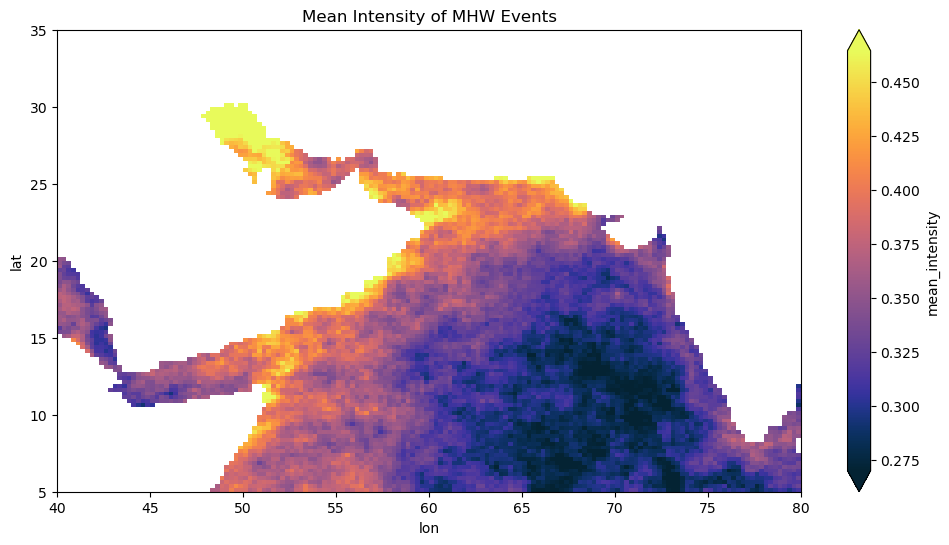

In [44]:
plt.figure(figsize=(12, 6))
mean_intensity_da.plot(cmap='cmo.thermal', robust=True)
plt.title('Mean Intensity of MHW Events')
plt.show()



In [46]:
cum_intensities = process_all_points(sst_anom, mhw,'cumulative_intensity')

Processing Grid Points:   0%|                                                                | 0/19200 [00:00<?, ?it/s]C:\Users\li3n23\AppData\Local\Temp\ipykernel_18832\2985200595.py:62: RuntimeWarning: Mean of empty slice
  mean_intensities[lat_idx, lon_idx] = np.nanmean(props[var])
Processing Grid Points: 100%|████████████████████████████████████████████████████| 19200/19200 [03:27<00:00, 92.32it/s]


In [49]:
cum_intensity_da = create_spatial_dataarray(cum_intensities, sst)


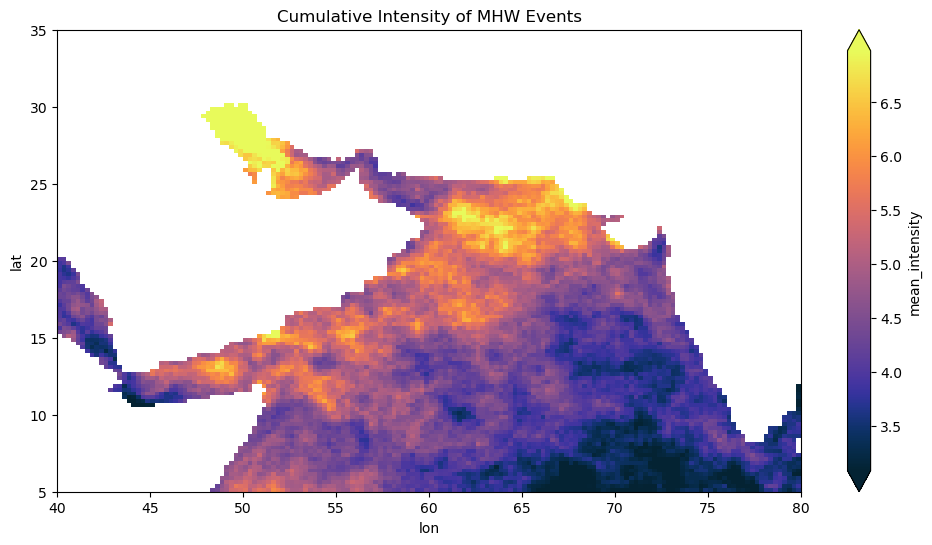

In [50]:
plt.figure(figsize=(12, 6))
cum_intensity_da.plot(cmap='cmo.thermal', robust=True)
plt.title('Cumulative Intensity of MHW Events')
plt.show()

